<a href="https://colab.research.google.com/github/giuseppemartino26/Semantic-SAM/blob/main/Bbox_SAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Questo notebook contiene il codice per l'implementazione della strategia Object Detection con YOLO-NAS + SAM.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#RIAVVIARE IL RUNTIME DOPO L'ESECUZIONE DI QUESTA CELLA
!pip install -q super-gradients==3.1.1
!pip install -q supervision
!pip install datasets
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 964.2/964.2 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 684.5/684.5 kB 64.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 103.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 108.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.6/408.6 kB 36.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 111.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 82.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 103.6 MB/s eta 0

In [ ]:
import torch
from super_gradients.training import models
import json
from tqdm import tqdm
import evaluate
import cv2
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("..")
import csv
import copy
import shutil

from datasets import load_metric


The console stream is logged into /root/sg_logs/console.log


[2023-05-29 09:09:04] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it
/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
[2023-05-29 09:09:10] WARNING - __init__.py - Failed to import pytorch_quantization
[2023-05-29 09:09:10] WARNING - calibrator.py - Failed to import pytorch_quantization
[2023-05-29 09:09:10] WARNING - export.py - Failed to import pytorch_quantization
[2023-05-29 09:09:10] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization
[2023-05-29 09:09:10] INFO - utils.py - NumExpr defaulting to 2 threads.


In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else "cpu"
MODEL_ARCH = 'yolo_nas_l'

model = models.get(MODEL_ARCH, pretrained_weights="coco").to(DEVICE)

[2023-05-29 09:09:11] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.


  0%|          | 0.00/256M [00:00<?, ?B/s]

Downloading: "https://sghub.deci.ai/models/yolo_nas_l_coco.pth" to /root/.cache/torch/hub/checkpoints/yolo_nas_l_coco.pth


In [ ]:
#Viene usato per convertire le label di YOLO nei valori delle classi di Pascal Voc
convert_to_pascal_voc = [15,2,7,14,1,6,19,0,4,0,0,0,0,0,3,8,12,13,17,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,18,16,0,11,0,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

###SAM

In [ ]:
using_colab = True

if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
    
    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
        
    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth


from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_predictor = SamPredictor(sam)

PyTorch version: 1.13.1+cu117
Torchvision version: 0.14.1+cu117
CUDA is available: True
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-7d01w6rd
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-7d01w6rd
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36589 sha256=0b74d88cad8b11e879713ad53c567a312def6804aea42e35a978591f6956b0ea
  Stored in directory: /tmp/pip-ephem-wheel-cache-quo_95s8/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built seg

###Funzioni

In [ ]:
def generate_predictions(mask_list, mask, labels):
  predictions = np.zeros(mask.shape)
  i = 0
  for mask in mask_list:
    for row in range(len(mask)):
      for col in range(len(mask[row])):
        if mask[row][col]:
          predictions[row][col] = convert_to_pascal_voc[int(labels[i])]
    i+= 1
  return predictions

def _get_voc_pallete(num_cls):
    n = num_cls
    pallete = [0]*(n*3)
    for j in range(0,n):
            lab = j
            pallete[j*3+0] = 0
            pallete[j*3+1] = 0
            pallete[j*3+2] = 0
            i = 0
            while (lab > 0):
                    pallete[j*3+0] |= (((lab >> 0) & 1) << (7-i))
                    pallete[j*3+1] |= (((lab >> 1) & 1) << (7-i))
                    pallete[j*3+2] |= (((lab >> 2) & 1) << (7-i))
                    i = i + 1
                    lab >>= 3
    return pallete

vocpallete = _get_voc_pallete(256)

adepallete = [0,0,0,120,120,120,180,120,120,6,230,230,80,50,50,4,200,3,120,120,80,140,140,140,204,5,255,230,230,230,4,250,7,224,5,255,235,255,7,150,5,61,120,120,70,8,255,51,255,6,82,143,255,140,204,255,4,255,51,7,204,70,3,0,102,200,61,230,250,255,6,51,11,102,255,255,7,71,255,9,224,9,7,230,220,220,220,255,9,92,112,9,255,8,255,214,7,255,224,255,184,6,10,255,71,255,41,10,7,255,255,224,255,8,102,8,255,255,61,6,255,194,7,255,122,8,0,255,20,255,8,41,255,5,153,6,51,255,235,12,255,160,150,20,0,163,255,140,140,140,250,10,15,20,255,0,31,255,0,255,31,0,255,224,0,153,255,0,0,0,255,255,71,0,0,235,255,0,173,255,31,0,255,11,200,200,255,82,0,0,255,245,0,61,255,0,255,112,0,255,133,255,0,0,255,163,0,255,102,0,194,255,0,0,143,255,51,255,0,0,82,255,0,255,41,0,255,173,10,0,255,173,255,0,0,255,153,255,92,0,255,0,255,255,0,245,255,0,102,255,173,0,255,0,20,255,184,184,0,31,255,0,255,61,0,71,255,255,0,204,0,255,194,0,255,82,0,10,255,0,112,255,51,0,255,0,194,255,0,122,255,0,255,163,255,153,0,0,255,10,255,112,0,143,255,0,82,0,255,163,255,0,255,235,0,8,184,170,133,0,255,0,255,92,184,0,255,255,0,31,0,184,255,0,214,255,255,0,112,92,255,0,0,224,255,112,224,255,70,184,160,163,0,255,153,0,255,71,255,0,255,0,163,255,204,0,255,0,143,0,255,235,133,255,0,255,0,235,245,0,255,255,0,122,255,245,0,10,190,212,214,255,0,0,204,255,20,0,255,255,255,0,0,153,255,0,41,255,0,255,204,41,0,255,41,255,0,173,0,255,0,245,255,71,0,255,122,0,255,0,255,184,0,92,255,184,255,0,0,133,255,255,214,0,25,194,194,102,255,0,92,0,255]

citypallete = [
128,64,128,244,35,232,70,70,70,102,102,156,190,153,153,153,153,153,250,170,30,220,220,0,107,142,35,152,251,152,70,130,180,220,20,60,255,0,0,0,0,142,0,0,70,0,60,100,0,80,100,0,0,230,119,11,32,128,192,0,0,64,128,128,64,128,0,192,128,128,192,128,64,64,0,192,64,0,64,192,0,192,192,0,64,64,128,192,64,128,64,192,128,192,192,128,0,0,64,128,0,64,0,128,64,128,128,64,0,0,192,128,0,192,0,128,192,128,128,192,64,0,64,192,0,64,64,128,64,192,128,64,64,0,192,192,0,192,64,128,192,192,128,192,0,64,64,128,64,64,0,192,64,128,192,64,0,64,192,128,64,192,0,192,192,128,192,192,64,64,64,192,64,64,64,192,64,192,192,64,64,64,192,192,64,192,64,192,192,192,192,192,32,0,0,160,0,0,32,128,0,160,128,0,32,0,128,160,0,128,32,128,128,160,128,128,96,0,0,224,0,0,96,128,0,224,128,0,96,0,128,224,0,128,96,128,128,224,128,128,32,64,0,160,64,0,32,192,0,160,192,0,32,64,128,160,64,128,32,192,128,160,192,128,96,64,0,224,64,0,96,192,0,224,192,0,96,64,128,224,64,128,96,192,128,224,192,128,32,0,64,160,0,64,32,128,64,160,128,64,32,0,192,160,0,192,32,128,192,160,128,192,96,0,64,224,0,64,96,128,64,224,128,64,96,0,192,224,0,192,96,128,192,224,128,192,32,64,64,160,64,64,32,192,64,160,192,64,32,64,192,160,64,192,32,192,192,160,192,192,96,64,64,224,64,64,96,192,64,224,192,64,96,64,192,224,64,192,96,192,192,224,192,192,0,32,0,128,32,0,0,160,0,128,160,0,0,32,128,128,32,128,0,160,128,128,160,128,64,32,0,192,32,0,64,160,0,192,160,0,64,32,128,192,32,128,64,160,128,192,160,128,0,96,0,128,96,0,0,224,0,128,224,0,0,96,128,128,96,128,0,224,128,128,224,128,64,96,0,192,96,0,64,224,0,192,224,0,64,96,128,192,96,128,64,224,128,192,224,128,0,32,64,128,32,64,0,160,64,128,160,64,0,32,192,128,32,192,0,160,192,128,160,192,64,32,64,192,32,64,64,160,64,192,160,64,64,32,192,192,32,192,64,160,192,192,160,192,0,96,64,128,96,64,0,224,64,128,224,64,0,96,192,128,96,192,0,224,192,128,224,192,64,96,64,192,96,64,64,224,64,192,224,64,64,96,192,192,96,192,64,224,192,192,224,192,32,32,0,160,32,0,32,160,0,160,160,0,32,32,128,160,32,128,32,160,128,160,160,128,96,32,0,224,32,0,96,160,0,224,160,0,96,32,128,224,32,128,96,160,128,224,160,128,32,96,0,160,96,0,32,224,0,160,224,0,32,96,128,160,96,128,32,224,128,160,224,128,96,96,0,224,96,0,96,224,0,224,224,0,96,96,128,224,96,128,96,224,128,224,224,128,32,32,64,160,32,64,32,160,64,160,160,64,32,32,192,160,32,192,32,160,192,160,160,192,96,32,64,224,32,64,96,160,64,224,160,64,96,32,192,224,32,192,96,160,192,224,160,192,32,96,64,160,96,64,32,224,64,160,224,64,32,96,192,160,96,192,32,224,192,160,224,192,96,96,64,224,96,64,96,224,64,224,224,64,96,96,192,224,96,192,96,224,192,0,0,0]

def get_mask_pallete(npimg, dataset='detail'):
    """Get image color pallete for visualizing masks"""
    # recovery boundary
    if dataset == 'pascal_voc':
        npimg[npimg==21] = 255
    # put colormap
    out_img = Image.fromarray(npimg.squeeze().astype('uint8'))
    if dataset == 'ade20k':
        out_img.putpalette(adepallete)
    elif dataset == 'citys':
        out_img.putpalette(citypallete)
    elif dataset in ('detail', 'pascal_voc', 'pascal_aug'):
        out_img.putpalette(vocpallete)
    return out_img


def write_segm_img(path, image, labels, palette="detail", alpha=0.5):
    """Write depth map to pfm and png file.

    Args:
        path (str): filepath without extension
        image (array): input image
        labels (array): labeling of the image
    """

    mask = get_mask_pallete(labels, "pascal_voc")

    img = Image.fromarray(np.uint8(255*image)).convert("RGBA")
    seg = mask.convert("RGBA")

    out = Image.blend(img, seg, alpha)

    out.save(path + ".png")

    return


def read_image(path):
    """Read image and output RGB image (0-1).

    Args:
        path (str): path to file

    Returns:
        array: RGB image (0-1)
    """
    img = cv2.imread(path)

    if img.ndim == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.0

    return img


###Definizioni delle metriche

In [ ]:
def dice_coefficient(class_matrix, matrix2):
  intersection = 0
  sum1 = 0
  sum2 = 0
  matrix2[matrix2 == 255] = False

  for i in range(0, len(class_matrix)):
        for j in range(0, len(class_matrix[i])):
          if matrix2[i][j] == class_matrix[i][j] and matrix2[i][j] != 0:
            intersection += 1

          if class_matrix[i][j] != 0 and class_matrix[i][j] != 255:
            sum1 += 1

          if matrix2[i][j] != 0:
            sum2 += 1
          
  dice = (2.0 * intersection) / (sum1 + sum2)
  return dice


def iou(class_matrix, matrix2):
  intersection = 0
  union = 0

  for i in range(0, len(class_matrix)):
        for j in range(0, len(class_matrix[i])):
          if matrix2[i][j] == class_matrix[i][j] and matrix2[i][j] != 0:
            intersection += 1

          if matrix2[i][j] != 0 or (class_matrix[i][j] != 0 and class_matrix[i][j] != 255):
            union += 1

  iou_score = intersection / union
  return iou_score

In [ ]:
"""Mean IoU (Intersection-over-Union) metric."""

from typing import Dict, Optional

import datasets
import numpy as np

import evaluate


_DESCRIPTION = """
IoU is the area of overlap between the predicted segmentation and the ground truth divided by the area of union
between the predicted segmentation and the ground truth. For binary (two classes) or multi-class segmentation,
the mean IoU of the image is calculated by taking the IoU of each class and averaging them.
"""

_KWARGS_DESCRIPTION = """
Args:
    predictions (`List[ndarray]`):
        List of predicted segmentation maps, each of shape (height, width). Each segmentation map can be of a different size.
    references (`List[ndarray]`):
        List of ground truth segmentation maps, each of shape (height, width). Each segmentation map can be of a different size.
    num_labels (`int`):
        Number of classes (categories).
    ignore_index (`int`):
        Index that will be ignored during evaluation.
    nan_to_num (`int`, *optional*):
        If specified, NaN values will be replaced by the number defined by the user.
    label_map (`dict`, *optional*):
        If specified, dictionary mapping old label indices to new label indices.
    reduce_labels (`bool`, *optional*, defaults to `False`):
        Whether or not to reduce all label values of segmentation maps by 1. Usually used for datasets where 0 is used for background,
        and background itself is not included in all classes of a dataset (e.g. ADE20k). The background label will be replaced by 255.

Returns:
    `Dict[str, float | ndarray]` comprising various elements:
    - *mean_iou* (`float`):
        Mean Intersection-over-Union (IoU averaged over all categories).
    - *mean_accuracy* (`float`):
        Mean accuracy (averaged over all categories).
    - *overall_accuracy* (`float`):
        Overall accuracy on all images.
    - *per_category_accuracy* (`ndarray` of shape `(num_labels,)`):
        Per category accuracy.
    - *per_category_iou* (`ndarray` of shape `(num_labels,)`):
        Per category IoU.

Examples:

    >>> import numpy as np

    >>> mean_iou = evaluate.load("mean_iou")

    >>> # suppose one has 3 different segmentation maps predicted
    >>> predicted_1 = np.array([[1, 2], [3, 4], [5, 255]])
    >>> actual_1 = np.array([[0, 3], [5, 4], [6, 255]])

    >>> predicted_2 = np.array([[2, 7], [9, 2], [3, 6]])
    >>> actual_2 = np.array([[1, 7], [9, 2], [3, 6]])

    >>> predicted_3 = np.array([[2, 2, 3], [8, 2, 4], [3, 255, 2]])
    >>> actual_3 = np.array([[1, 2, 2], [8, 2, 1], [3, 255, 1]])

    >>> predicted = [predicted_1, predicted_2, predicted_3]
    >>> ground_truth = [actual_1, actual_2, actual_3]

    >>> results = mean_iou.compute(predictions=predicted, references=ground_truth, num_labels=10, ignore_index=255, reduce_labels=False)
    >>> print(results) # doctest: +NORMALIZE_WHITESPACE
    {'mean_iou': 0.47750000000000004, 'mean_accuracy': 0.5916666666666666, 'overall_accuracy': 0.5263157894736842, 'per_category_iou': array([0.   , 0.   , 0.375, 0.4  , 0.5  , 0.   , 0.5  , 1.   , 1.   , 1.   ]), 'per_category_accuracy': array([0.        , 0.        , 0.75      , 0.66666667, 1.        , 0.        , 0.5       , 1.        , 1.        , 1.        ])}
"""

_CITATION = """\
@software{MMSegmentation_Contributors_OpenMMLab_Semantic_Segmentation_2020,
author = {{MMSegmentation Contributors}},
license = {Apache-2.0},
month = {7},
title = {{OpenMMLab Semantic Segmentation Toolbox and Benchmark}},
url = {https://github.com/open-mmlab/mmsegmentation},
year = {2020}
}"""


def intersect_and_union(
    pred_label,
    label,
    num_labels,
    ignore_index: bool,
    label_map: Optional[Dict[int, int]] = None,
    reduce_labels: bool = False,
):
    """Calculate intersection and Union.

    Args:
        pred_label (`ndarray`):
            Prediction segmentation map of shape (height, width).
        label (`ndarray`):
            Ground truth segmentation map of shape (height, width).
        num_labels (`int`):
            Number of categories.
        ignore_index (`int`):
            Index that will be ignored during evaluation.
        label_map (`dict`, *optional*):
            Mapping old labels to new labels. The parameter will work only when label is str.
        reduce_labels (`bool`, *optional*, defaults to `False`):
            Whether or not to reduce all label values of segmentation maps by 1. Usually used for datasets where 0 is used for background,
            and background itself is not included in all classes of a dataset (e.g. ADE20k). The background label will be replaced by 255.

     Returns:
         area_intersect (`ndarray`):
            The intersection of prediction and ground truth histogram on all classes.
         area_union (`ndarray`):
            The union of prediction and ground truth histogram on all classes.
         area_pred_label (`ndarray`):
            The prediction histogram on all classes.
         area_label (`ndarray`):
            The ground truth histogram on all classes.
    """
    if label_map is not None:
        for old_id, new_id in label_map.items():
            label[label == old_id] = new_id

    # turn into Numpy arrays
    pred_label = np.array(pred_label)
    label = np.array(label)

    if reduce_labels:
        label[label == 0] = 255
        label = label - 1
        label[label == 254] = 255

        pred_label[pred_label == 0] = 255
        pred_label = pred_label - 1
        pred_label[pred_label == 254] = 255

    mask = label != ignore_index
    mask = np.not_equal(label, ignore_index)
    pred_label = pred_label[mask]
    label = np.array(label)[mask]

    intersect = pred_label[pred_label == label]

    area_intersect = np.histogram(intersect, bins=num_labels, range=(0, num_labels - 1))[0]
    area_pred_label = np.histogram(pred_label, bins=num_labels, range=(0, num_labels - 1))[0]
    area_label = np.histogram(label, bins=num_labels, range=(0, num_labels - 1))[0]

    area_union = area_pred_label + area_label - area_intersect

    return area_intersect, area_union, area_pred_label, area_label


def total_intersect_and_union(
    results,
    gt_seg_maps,
    num_labels,
    ignore_index: bool,
    label_map: Optional[Dict[int, int]] = None,
    reduce_labels: bool = False,
):
    """Calculate Total Intersection and Union, by calculating `intersect_and_union` for each (predicted, ground truth) pair.

    Args:
        results (`ndarray`):
            List of prediction segmentation maps, each of shape (height, width).
        gt_seg_maps (`ndarray`):
            List of ground truth segmentation maps, each of shape (height, width).
        num_labels (`int`):
            Number of categories.
        ignore_index (`int`):
            Index that will be ignored during evaluation.
        label_map (`dict`, *optional*):
            Mapping old labels to new labels. The parameter will work only when label is str.
        reduce_labels (`bool`, *optional*, defaults to `False`):
            Whether or not to reduce all label values of segmentation maps by 1. Usually used for datasets where 0 is used for background,
            and background itself is not included in all classes of a dataset (e.g. ADE20k). The background label will be replaced by 255.

     Returns:
         total_area_intersect (`ndarray`):
            The intersection of prediction and ground truth histogram on all classes.
         total_area_union (`ndarray`):
            The union of prediction and ground truth histogram on all classes.
         total_area_pred_label (`ndarray`):
            The prediction histogram on all classes.
         total_area_label (`ndarray`):
            The ground truth histogram on all classes.
    """
    total_area_intersect = np.zeros((num_labels,), dtype=np.float64)
    total_area_union = np.zeros((num_labels,), dtype=np.float64)
    total_area_pred_label = np.zeros((num_labels,), dtype=np.float64)
    total_area_label = np.zeros((num_labels,), dtype=np.float64)
    for result, gt_seg_map in zip(results, gt_seg_maps):
        area_intersect, area_union, area_pred_label, area_label = intersect_and_union(
            result, gt_seg_map, num_labels, ignore_index, label_map, reduce_labels
        )
        total_area_intersect += area_intersect
        total_area_union += area_union
        total_area_pred_label += area_pred_label
        total_area_label += area_label
    return total_area_intersect, total_area_union, total_area_pred_label, total_area_label


def mean_iou(
    results,
    gt_seg_maps,
    num_labels,
    ignore_index: bool,
    nan_to_num: Optional[int] = None,
    label_map: Optional[Dict[int, int]] = None,
    reduce_labels: bool = False,
):
    """Calculate Mean Intersection and Union (mIoU).

    Args:
        results (`ndarray`):
            List of prediction segmentation maps, each of shape (height, width).
        gt_seg_maps (`ndarray`):
            List of ground truth segmentation maps, each of shape (height, width).
        num_labels (`int`):
            Number of categories.
        ignore_index (`int`):
            Index that will be ignored during evaluation.
        nan_to_num (`int`, *optional*):
            If specified, NaN values will be replaced by the number defined by the user.
        label_map (`dict`, *optional*):
            Mapping old labels to new labels. The parameter will work only when label is str.
        reduce_labels (`bool`, *optional*, defaults to `False`):
            Whether or not to reduce all label values of segmentation maps by 1. Usually used for datasets where 0 is used for background,
            and background itself is not included in all classes of a dataset (e.g. ADE20k). The background label will be replaced by 255.

    Returns:
        `Dict[str, float | ndarray]` comprising various elements:
        - *mean_iou* (`float`):
            Mean Intersection-over-Union (IoU averaged over all categories).
        - *mean_accuracy* (`float`):
            Mean accuracy (averaged over all categories).
        - *overall_accuracy* (`float`):
            Overall accuracy on all images.
        - *per_category_accuracy* (`ndarray` of shape `(num_labels,)`):
            Per category accuracy.
        - *per_category_iou* (`ndarray` of shape `(num_labels,)`):
            Per category IoU.
    """
    total_area_intersect, total_area_union, total_area_pred_label, total_area_label = total_intersect_and_union(
        results, gt_seg_maps, num_labels, ignore_index, label_map, reduce_labels
    )

    # compute metrics
    metrics = dict()

    all_acc = total_area_intersect.sum() / total_area_label.sum()
    iou = total_area_intersect / total_area_union
    acc = total_area_intersect / total_area_label

    metrics["mean_iou"] = np.nanmean(iou)
    metrics["mean_accuracy"] = np.nanmean(acc)
    metrics["overall_accuracy"] = all_acc
    metrics["per_category_iou"] = iou
    metrics["per_category_accuracy"] = acc

    if nan_to_num is not None:
        metrics = dict(
            {metric: np.nan_to_num(metric_value, nan=nan_to_num) for metric, metric_value in metrics.items()}
        )

    return metrics


@evaluate.utils.file_utils.add_start_docstrings(_DESCRIPTION, _KWARGS_DESCRIPTION)
class MeanIoU(evaluate.Metric):
    def _info(self):
        return evaluate.MetricInfo(
            description=_DESCRIPTION,
            citation=_CITATION,
            inputs_description=_KWARGS_DESCRIPTION,
            features=datasets.Features(
                # 1st Seq - height dim, 2nd - width dim
                {
                    "predictions": datasets.Sequence(datasets.Sequence(datasets.Value("uint16"))),
                    "references": datasets.Sequence(datasets.Sequence(datasets.Value("uint16"))),
                }
            ),
            reference_urls=[
                "https://github.com/open-mmlab/mmsegmentation/blob/71c201b1813267d78764f306a297ca717827c4bf/mmseg/core/evaluation/metrics.py"
            ],
        )

    def _compute(
        self,
        predictions,
        references,
        num_labels: int,
        ignore_index: bool,
        nan_to_num: Optional[int] = None,
        label_map: Optional[Dict[int, int]] = None,
        reduce_labels: bool = False,
    ):
        iou_result = mean_iou(
            results=predictions,
            gt_seg_maps=references,
            num_labels=num_labels,
            ignore_index=ignore_index,
            nan_to_num=nan_to_num,
            label_map=label_map,
            reduce_labels=reduce_labels,
        )
        return iou_result

In [ ]:
  cartella_immagini = '/content/drive/MyDrive/ProgettoSEAI/data/pascal_voc/JPEGImages/'
  # Ottieni la lista dei file nella cartella
  elenco_file = os.listdir(cartella_immagini)
  elenco_file.sort()
  parti = np.array_split(elenco_file, 3)
  # Loop attraverso tutti i file nella cartella
  
  dict_metrics= {} 
  #peppe:parti0 , 1, 2,3,4,5,6,7
  #salvo: 8,9,10,11,12,13,14,15 
  part = 0
  for img_name in tqdm(parti[part]):
      iou_sem_sam = {}
      dice_sem_sam = {}
      m_iou_sem_sam = {}
      img_name = img_name[:img_name.rindex(".")]
    
      img_path = f'/content/drive/MyDrive/ProgettoSEAI/data/pascal_voc/JPEGImages/{img_name}.jpg'
      ground_truth = f'/content/drive/MyDrive/ProgettoSEAI/data/pascal_voc/SegmentationClass/{img_name}.png'
      dir_output = f"/content/drive/MyDrive/results_only_match/output_bb/{img_name}"
      # Verifica se la cartella esiste già
      if os.path.exists(dir_output):
          # Elimina la cartella se esiste già
          shutil.rmtree(dir_output)


      # Crea la cartella
      os.mkdir(dir_output)

      #Carico l'immagine ground truth ed estraggo i valori delle classi
      segmentation_true = Image.open(ground_truth)
      segmentation_array = np.array(segmentation_true)
      class_matrix = segmentation_array.astype(int)

      #BOUNDING BOX
      image = cv2.imread(img_path)
      result = list(model.predict(image, conf=0.5))[0] #provare a cambiare la soglia

      labels = result.prediction.labels

      #GENERO LE MASCHERE PER OGNI BOUNDING BOX
      image_bgr = cv2.imread(img_path)
      image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
      
      mask_predictor.set_image(image_rgb)
      #Ogni elemento di "mask_list" conterrà una maschera generata a partire da un bounding box
      mask_list = []
      for i in range(result.prediction.bboxes_xyxy.shape[0]):
        mask, scores, logits = mask_predictor.predict(
            box=result.prediction.bboxes_xyxy[i],
            multimask_output=False
        )
        mask = mask[0] #Per ottenere una shape 2x2
        mask_list.append(mask)

      #Ottengo le predictions
      predictions = generate_predictions(mask_list, class_matrix, labels)

      iou_sem_sam["iou_sem_sam"] = iou(class_matrix, predictions)
      dice_sem_sam["dice_sem_sam"] = dice_coefficient(class_matrix, predictions)
      m_iou_sem_sam["m_iou_sem_sam"] = mean_iou(predictions, class_matrix, num_labels=21, ignore_index=255)["mean_iou"]
      dict_metrics[img_name] = [iou_sem_sam,dice_sem_sam,m_iou_sem_sam]
      #plt.close('all')

      #SOVRAPPOSIZIONE SEGMENTAZIONI ALL'IMMAGINE ORIGINALE
      img = read_image(img_path)
      write_segm_img(f'/content/drive/MyDrive/ProgettoSEAI/output/{img_name}/obj_plus_sam', img, predictions, alpha=0.5)
      
      

      

  with open(f"/content/drive/MyDrive/results_only_match/metriche_bb/dict_metrics{part}.json", "w") as file:
    Scrivi il dizionario nel file in formato JSON
    json.dump(dict_metrics, file)

  0%|          | 0/483 [00:00<?, ?it/s]<ipython-input-7-f358f69149c5>:250: RuntimeWarning: invalid value encountered in true_divide
  iou = total_area_intersect / total_area_union
<ipython-input-7-f358f69149c5>:251: RuntimeWarning: invalid value encountered in true_divide
  acc = total_area_intersect / total_area_label
  0%|          | 0/483 [00:02<?, ?it/s]


#Calcolo metriche solo per il subset del val set

In [ ]:
  cartella_immagini = '/content/drive/MyDrive/ProgettoSEAI/data/pascal_voc/JPEGImages/'
  # Ottieni la lista dei file nella cartella
  elenco_file = os.listdir(cartella_immagini)
  elenco_file.sort()
  parti = np.array_split(elenco_file, 3)
  # Loop attraverso tutti i file nella cartella
  
  dict_metrics= {} 
  #peppe:parti0 , 1, 2,3,4,5,6,7
  #salvo: 8,9,10,11,12,13,14,15 
  part = 2
  for img_name in tqdm(parti[part]):
      iou_sem_sam = {}
      dice_sem_sam = {}
      m_iou_sem_sam = {}
      img_name = img_name[:img_name.rindex(".")]
    
      img_path = f'/content/drive/MyDrive/ProgettoSEAI/data/pascal_voc/JPEGImages/{img_name}.jpg'
      ground_truth = f'/content/drive/MyDrive/ProgettoSEAI/data/pascal_voc/SegmentationClass/{img_name}.png'
      #dir_output = f"/content/drive/MyDrive/results_only_match/output_bb/{img_name}"
      # Verifica se la cartella esiste già
      #if os.path.exists(dir_output):
          # Elimina la cartella se esiste già
          #shutil.rmtree(dir_output)


      # Crea la cartella
      #os.mkdir(dir_output)

      #Carico l'immagine ground truth ed estraggo i valori delle classi
      segmentation_true = Image.open(ground_truth)
      segmentation_array = np.array(segmentation_true)
      class_matrix = segmentation_array.astype(int)

      class_ade20k_convertion=[91,128,0,77,99,81,21,0,20,0,0,0,0,117,13,0,0,24,0,0]

       #controllo se nell'immagine di segmentazione truth è vuota per ADE20K
      class_sem = np.unique(class_matrix)[1:-1]
      exist_class_sem = 0
      for a in class_sem:
        if class_ade20k_convertion[a - 1] == 0:
          exist_class_sem += 1
      if exist_class_sem > 0:
        continue 



      #BOUNDING BOX
      image = cv2.imread(img_path)
      result = list(model.predict(image, conf=0.5))[0] #provare a cambiare la soglia

      labels = result.prediction.labels

      #GENERO LE MASCHERE PER OGNI BOUNDING BOX
      image_bgr = cv2.imread(img_path)
      image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
      
      mask_predictor.set_image(image_rgb)
      #Ogni elemento di "mask_list" conterrà una maschera generata a partire da un bounding box
      mask_list = []
      for i in range(result.prediction.bboxes_xyxy.shape[0]):
        mask, scores, logits = mask_predictor.predict(
            box=result.prediction.bboxes_xyxy[i],
            multimask_output=False
        )
        mask = mask[0] #Per ottenere una shape 2x2
        mask_list.append(mask)

      #Ottengo le predictions
      predictions = generate_predictions(mask_list, class_matrix, labels)

      iou_sem_sam["iou_sem_sam"] = iou(class_matrix, predictions)
      dice_sem_sam["dice_sem_sam"] = dice_coefficient(class_matrix, predictions)
      m_iou_sem_sam["m_iou_sem_sam"] = mean_iou(predictions, class_matrix, num_labels=21, ignore_index=255)["mean_iou"]
      dict_metrics[img_name] = [iou_sem_sam,dice_sem_sam,m_iou_sem_sam]
      #plt.close('all')

      #SOVRAPPOSIZIONE SEGMENTAZIONI ALL'IMMAGINE ORIGINALE
      #img = read_image(img_path)
      #write_segm_img(f'/content/drive/MyDrive/ProgettoSEAI/output/{img_name}/obj_plus_sam', img, predictions, alpha=0.5)

      
      
      

      

  with open(f"/content/drive/MyDrive/results_only_match/metriche_bb_subset/dict_metrics{part}.json", "w") as file:
    #Scrivi il dizionario nel file in formato JSON
    json.dump(dict_metrics, file)

  0%|          | 0/483 [00:00<?, ?it/s]<ipython-input-7-f358f69149c5>:250: RuntimeWarning: invalid value encountered in true_divide
  iou = total_area_intersect / total_area_union
<ipython-input-7-f358f69149c5>:251: RuntimeWarning: invalid value encountered in true_divide
  acc = total_area_intersect / total_area_label
100%|█████████▉| 482/483 [13:25<00:01,  1.27s/it]

#Eseguire Solo per report

In [ ]:
  cartella_immagini = '/content/drive/MyDrive/ProgettoSEAI/data/pascal_voc/JPEGImages/'
  # Ottieni la lista dei file nella cartella
  elenco_file = os.listdir(cartella_immagini)
  elenco_file.sort()
  parti = np.array_split(elenco_file, 3)
  # Loop attraverso tutti i file nella cartella
  
  dict_metrics= {} 
  #peppe:parti0 , 1, 2,3,4,5,6,7
  #salvo: 8,9,10,11,12,13,14,15 
  part = 0
  for img_name in tqdm(parti[part]):
      iou_sem_sam = {}
      dice_sem_sam = {}
      m_iou_sem_sam = {}
      img_name = img_name[:img_name.rindex(".")]
    
      img_path = f'/content/drive/MyDrive/ProgettoSEAI/data/pascal_voc/JPEGImages/2007_002376.jpg'
      ground_truth = f'/content/drive/MyDrive/ProgettoSEAI/data/pascal_voc/SegmentationClass/2007_002376.png'
      dir_output = f"/content/drive/MyDrive/results_only_match/output_bb/2007_002376"
      # Verifica se la cartella esiste già
      #if os.path.exists(dir_output):
          # Elimina la cartella se esiste già
          #shutil.rmtree(dir_output)


      # Crea la cartella
      #os.mkdir(dir_output)

      #Carico l'immagine ground truth ed estraggo i valori delle classi
      segmentation_true = Image.open(ground_truth)
      segmentation_array = np.array(segmentation_true)
      class_matrix = segmentation_array.astype(int)

      #BOUNDING BOX
      image = cv2.imread(img_path)
      result = list(model.predict(image, conf=0.5))[0] #provare a cambiare la soglia

      labels = result.prediction.labels

      #GENERO LE MASCHERE PER OGNI BOUNDING BOX
      image_bgr = cv2.imread(img_path)
      image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
      
      mask_predictor.set_image(image_rgb)
      #Ogni elemento di "mask_list" conterrà una maschera generata a partire da un bounding box
      mask_list = []
      for i in range(result.prediction.bboxes_xyxy.shape[0]):
        mask, scores, logits = mask_predictor.predict(
            box=result.prediction.bboxes_xyxy[i],
            multimask_output=False
        )
        mask = mask[0] #Per ottenere una shape 2x2
        mask_list.append(mask)

      #Ottengo le predictions
      predictions = generate_predictions(mask_list, class_matrix, labels)

      iou_sem_sam["iou_sem_sam"] = iou(class_matrix, predictions)
      dice_sem_sam["dice_sem_sam"] = dice_coefficient(class_matrix, predictions)
      m_iou_sem_sam["m_iou_sem_sam"] = mean_iou(predictions, class_matrix, num_labels=21, ignore_index=255)["mean_iou"]
      dict_metrics[img_name] = [iou_sem_sam,dice_sem_sam,m_iou_sem_sam]
      #plt.close('all')

      #SOVRAPPOSIZIONE SEGMENTAZIONI ALL'IMMAGINE ORIGINALE
      #img = read_image(img_path)
      #write_segm_img(f'/content/drive/MyDrive/ProgettoSEAI/output/{img_name}/obj_plus_sam', img, predictions, alpha=0.5)

      break
      
      

      

  #with open(f"/content/drive/MyDrive/results_only_match/metriche_bb/dict_metrics{part}.json", "w") as file:
    #Scrivi il dizionario nel file in formato JSON
    #json.dump(dict_metrics, file)

  0%|          | 0/483 [00:00<?, ?it/s]<ipython-input-7-f358f69149c5>:250: RuntimeWarning: invalid value encountered in true_divide
  iou = total_area_intersect / total_area_union
<ipython-input-7-f358f69149c5>:251: RuntimeWarning: invalid value encountered in true_divide
  acc = total_area_intersect / total_area_label
  0%|          | 0/483 [00:02<?, ?it/s]


In [ ]:
mask_list[0]

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

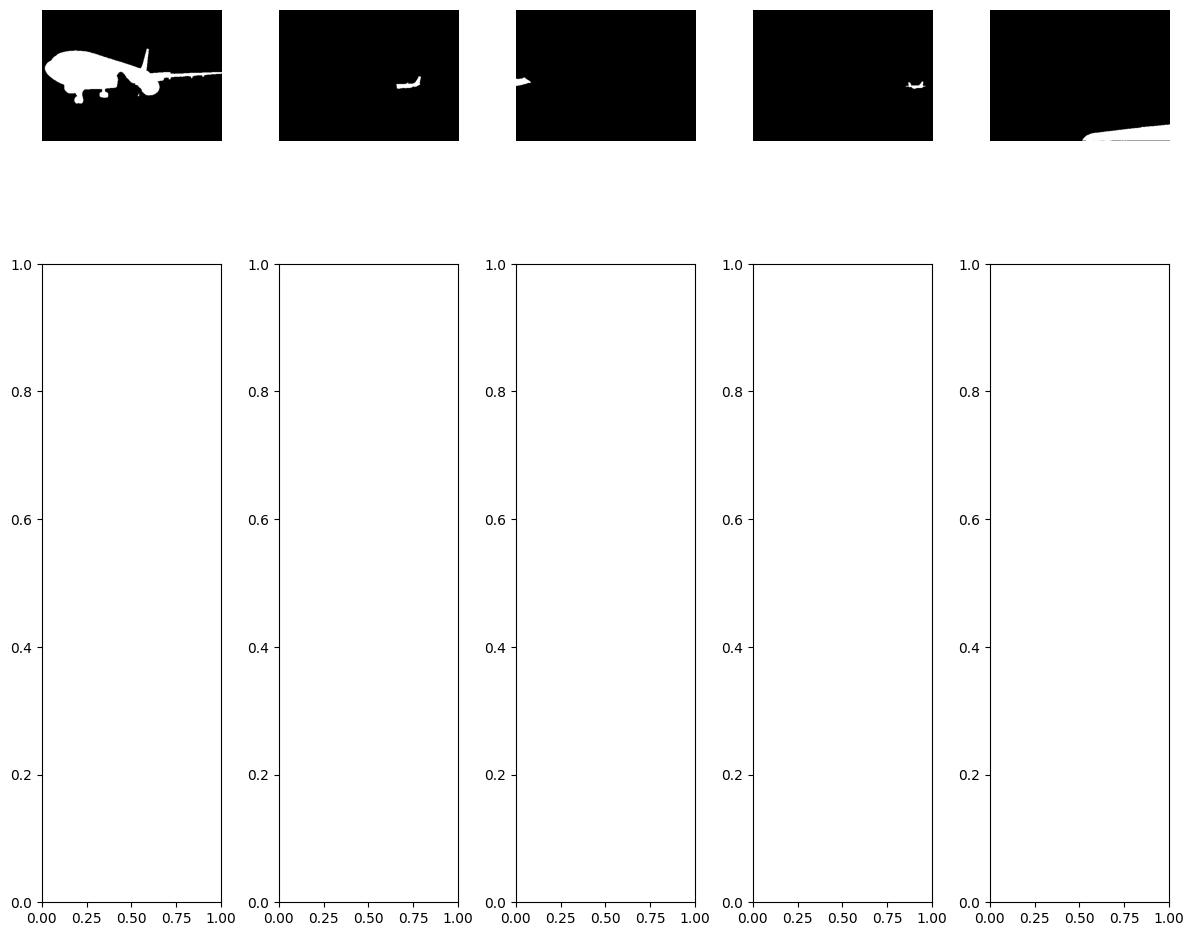

In [ ]:
import matplotlib.pyplot as plt

# Definisci il numero di righe e colonne del plot
num_righe = 2
num_colonne = 5

# Crea il plot con le dimensioni specificate
fig, axs = plt.subplots(num_righe, num_colonne, figsize=(12, 12))

# Itera attraverso il vettore di immagini e mostra ogni immagine nel plot
for i, img in enumerate(mask_list):
    riga = i // num_colonne
    colonna = i % num_colonne
    axs[riga, colonna].imshow(img, cmap='gray')
    axs[riga, colonna].axis('off')

# Mostra il plot
plt.tight_layout()
plt.show()

###Visualization

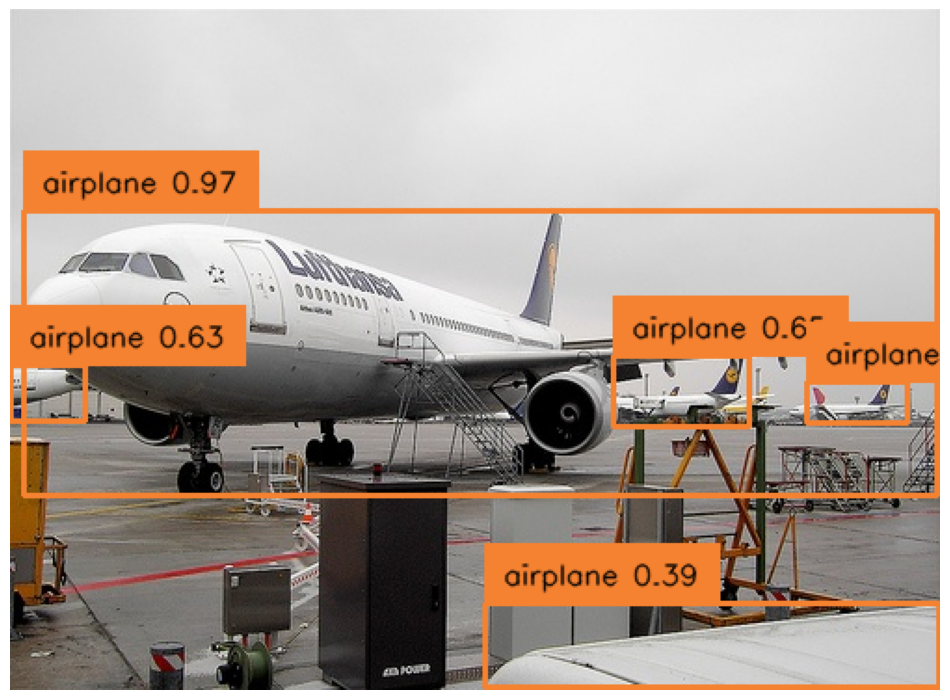

In [ ]:
#BOUNDING BOX
import supervision as sv

detections = sv.Detections(
    xyxy=result.prediction.bboxes_xyxy,
    confidence=result.prediction.confidence,
    class_id=result.prediction.labels.astype(int)
)

box_annotator = sv.BoxAnnotator()

labels = [
    f"{result.class_names[class_id]} {confidence:0.2f}"
    for _, _, confidence, class_id, _
    in detections
]

annotated_frame = box_annotator.annotate(
    scene=image.copy(),
    detections=detections,
    labels=labels
)

%matplotlib inline
sv.plot_image(annotated_frame, (12, 12))

In [ ]:
#SOVRAPPOSIZIONE SEGMENTAZIONI ALL'IMMAGINE ORIGINALE
img = read_image(img_path)
write_segm_img(f'{dir_output}/sem_plus_sam', img, predictions, alpha=0.5)

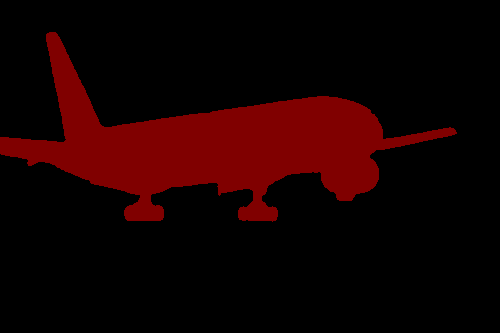

In [ ]:
#CONFRONTO CON IL GROUND TRUTH
from PIL import Image

mask_sem = get_mask_pallete(predictions, "pascal_voc")
img_sem_bb = mask_sem.convert("RGBA")

img_sem_bb

In [ ]:
file_path = "/content/drive/MyDrive/ProgettoSEAI/output/2007_000033/final_mask_sem_sam.npy"
if os.path.exists(file_path):
    print("Il file esiste!")
else:
    print("Il file non esiste.")


Il file esiste!


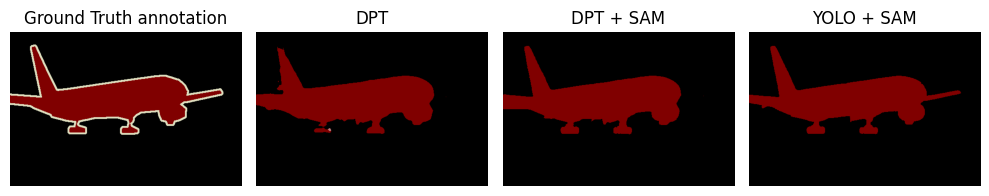

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

sem_sam = np.load("/content/drive/MyDrive/ProgettoSEAI/output/2007_002376/final_mask_sem_sam.npy")
sem = np.load("/content/drive/MyDrive/ProgettoSEAI/output/2007_002376/sem_mask_sem_sam.npy")
gt = Image.open("/content/drive/MyDrive/ProgettoSEAI/data/pascal_voc/SegmentationClass/2007_002376.png")

# Crea una griglia di sottoplot 1x3
fig, axes = plt.subplots(1, 4, figsize=(10, 8))

# Visualizza le immagini nei sottoplot
axes[0].imshow(gt)
axes[0].axis('off')
axes[0].set_title("Ground Truth annotation")

axes[1].imshow(sem)
axes[1].axis('off')
axes[1].set_title("DPT")

axes[2].imshow(sem_sam)
axes[2].axis('off')
axes[2].set_title("DPT + SAM")

axes[3].imshow(img_sem_bb)
axes[3].axis('off')
axes[3].set_title("YOLO + SAM")

# Regola automaticamente il layout dei sottoplot
plt.tight_layout()

# Mostra il plot
plt.show()


In [ ]:
for i in range(len(result.class_names)):
  print(f"{i} - {result.class_names[i]}")

0 - person
1 - bicycle
2 - car
3 - motorcycle
4 - airplane
5 - bus
6 - train
7 - truck
8 - boat
9 - traffic light
10 - fire hydrant
11 - stop sign
12 - parking meter
13 - bench
14 - bird
15 - cat
16 - dog
17 - horse
18 - sheep
19 - cow
20 - elephant
21 - bear
22 - zebra
23 - giraffe
24 - backpack
25 - umbrella
26 - handbag
27 - tie
28 - suitcase
29 - frisbee
30 - skis
31 - snowboard
32 - sports ball
33 - kite
34 - baseball bat
35 - baseball glove
36 - skateboard
37 - surfboard
38 - tennis racket
39 - bottle
40 - wine glass
41 - cup
42 - fork
43 - knife
44 - spoon
45 - bowl
46 - banana
47 - apple
48 - sandwich
49 - orange
50 - broccoli
51 - carrot
52 - hot dog
53 - pizza
54 - donut
55 - cake
56 - chair
57 - couch
58 - potted plant
59 - bed
60 - dining table
61 - toilet
62 - tv
63 - laptop
64 - mouse
65 - remote
66 - keyboard
67 - cell phone
68 - microwave
69 - oven
70 - toaster
71 - sink
72 - refrigerator
73 - book
74 - clock
75 - vase
76 - scissors
77 - teddy bear
78 - hair drier
79 - 

In [ ]:
print(f"DICE: {dice_coefficient(class_matrix,predictions)}")
print(f"IOU: {iou(class_matrix,predictions)}")
print(mean_iou(predictions, class_matrix, num_labels=21, ignore_index=255)["mean_iou"])

DICE: 0.9322648222658199
IOU: 0.8731236374961071
0.9423660581967697


<ipython-input-8-f358f69149c5>:250: RuntimeWarning: invalid value encountered in true_divide
  iou = total_area_intersect / total_area_union
<ipython-input-8-f358f69149c5>:251: RuntimeWarning: invalid value encountered in true_divide
  acc = total_area_intersect / total_area_label


###Confronto con diverse confidence

In [ ]:
import json

diz = {}
value = 0.3
path_folder = '/content/drive/MyDrive/results_only_match/metriche_bb'

files = os.listdir(path_folder)
files_ordinati = sorted(files)

for nome_file in files_ordinati:
  print(nome_file)

  m_iou_sem_sam_list = []

  # Leggi il file JSON
  with open(path_folder + '/' +nome_file, 'r') as f:
      data = json.load(f)

  # Itera su ogni oggetto nel dizionario
  for key in data:
      object_data = data[key]

      m_iou_sem_sam_value = [d['m_iou_sem_sam'] for d in object_data if 'm_iou_sem_sam' in d]
      m_iou_sem_sam_list.append(m_iou_sem_sam_value)

  m_iou_sem_sam_list = np.array(m_iou_sem_sam_list).flatten()
  m_iou_sem_sam_mean = np.mean(m_iou_sem_sam_list)
  diz[value] = m_iou_sem_sam_mean
  value +=0.1

diz

{0.3: 0.8134333719406427,
 0.4: 0.8406308293292523,
 0.5: 0.8522998229908734,
 0.6: 0.8315396390426362,
 0.7: 0.8290608972139749,
 0.7999999999999999: 0.7894863774908185}

dict_metrics0_0.3.json
dict_metrics0_0.4.json
dict_metrics0_0.5.json
dict_metrics0_0.6.json
dict_metrics0_0.7.json
dict_metrics0_0.8.json


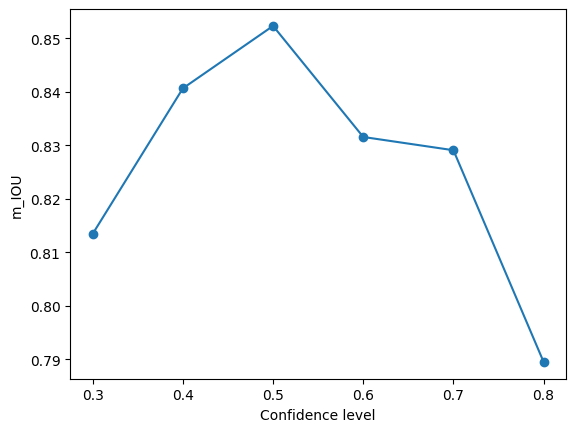

In [ ]:
import matplotlib.pyplot as plt

chiavi = list(diz.keys())
valori = list(diz.values())

# Plot dei valori
plt.plot(chiavi, valori, marker='o')

plt.xlabel('Confidence level')
plt.ylabel('m_IOU')
#plt.title('Grafico dei valori del dizionario')

# Mostrare il plot
plt.show()
